In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [6]:
# LOAD AND PREPROCESS IMAGES

def load_images(data_dir, img_size=128):

    images = []
    labels = []
    class_names = []
    
    # Get all person folders
    person_folders = sorted([f for f in os.listdir(data_dir) 
                            if os.path.isdir(os.path.join(data_dir, f))])
    
    print(f"Found {len(person_folders)} people")
    
    # Go through each person folder
    for person_idx, person_name in enumerate(person_folders):
        person_path = os.path.join(data_dir, person_name)
        
        # Get all images in this person's folder
        image_files = [f for f in os.listdir(person_path) 
                      if f.endswith(('.jpg', '.jpeg', '.png', 'JPG'))]
        
        print(f"  {person_name}: {len(image_files)} images")
        
        # Load each image
        for img_file in image_files:
            img_path = os.path.join(person_path, img_file)
            
            # Read image
            img = cv2.imread(img_path)
            
            # Skip if can't read
            if img is None:
                continue
            
            # Resize to target size
            img = cv2.resize(img, (img_size, img_size))
            
            # Convert from BGR to RGB (OpenCV reads as BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Add to lists
            images.append(img)
            labels.append(person_idx)
        
        class_names.append(person_name)
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"\nTotal images loaded: {len(X)}")
    print(f"Image shape: {X.shape}")
    
    return X, y, class_names

In [7]:
DATA_PATH = "/kaggle/input/cvpr-face-data-35-student/CVPR_face_data"
IMG_SIZE = 128
    
#  Load data
print(" Loading images...")
X, y, class_names = load_images(DATA_PATH, IMG_SIZE)

 Loading images...
Found 35 people
  21-45902-3: 20 images
  22-46139-1: 20 images
  22-46258-1: 15 images
  22-46275-1: 20 images
  22-46536-1: 9 images
  22-46590-1: 20 images
  22-47813-2: 19 images
  22-47892-2: 20 images
  22-47934-2: 20 images
  22-47968-2: 20 images
  22-48005-2: 20 images
  22-48021-2: 15 images
  22-48023-2: 13 images
  22-48064-2: 20 images
  22-48133-2: 21 images
  22-48205-2: 8 images
  22-48354-3: 20 images
  22-48569-3: 20 images
  22-48582-3: 20 images
  22-48833-3: 20 images
  22-49037-3: 19 images
  22-49068-3: 20 images
  22-49196-3: 20 images
  22-49338-3: 20 images
  22-49355-3: 20 images
  22-49421-3: 20 images
  22-49453-3: 25 images
  22-49643-3: 11 images
  22-49783-3: 20 images
  22-49791-3: 20 images
  22-49824-3: 20 images
  22-49843-3: 20 images
  22-49852-3: 19 images
  23-50254-1: 20 images
  23-50346-1: 41 images

Total images loaded: 655
Image shape: (655, 128, 128, 3)


In [8]:
def prepare_data(X, y, test_size=0.2):
    """
    Normalize images and split into train/validation sets.
    """
    # Normalize: convert 0-255 to 0-1
    X = X.astype('float32') / 255.0
    
    # FIX: Use max label + 1 to get correct num_classes
    num_classes = int(np.max(y)) + 1
    
    print(f"Number of classes: {num_classes}")
    print(f"Label range: {np.min(y)} to {np.max(y)}")
    
    # Convert labels to one-hot encoding
    y = tf.keras.utils.to_categorical(y, num_classes)
    
    # Split into training (80%) and validation (20%) sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42,
        stratify=np.argmax(y, axis=1)  # Keep distribution balanced
    )
    
    print(f"\nData Split:")
    print(f"  Training: {X_train.shape[0]} images")
    print(f"  Validation: {X_val.shape[0]} images")
    
    return X_train, X_val, y_train, y_val, num_classes


In [9]:
#  Prepare data
print("Preparing data...")
X_train, X_val, y_train, y_val, num_classes = prepare_data(X, y)

Preparing data...
Number of classes: 35
Label range: 0 to 34

Data Split:
  Training: 524 images
  Validation: 131 images


In [ ]:
# CNN MODEL

def build_simple_cnn(img_size=128, num_classes=35):

    model = models.Sequential([
        layers.Input(shape=(img_size, img_size, 3)),

        # --- Block 1 ---
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),

        # --- Block 2 ---
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),

        # --- Block 3 ---
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),
        
        # --- Block 4 ---
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),


        # --- Fully Connected ---
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [11]:
print(" Building model...")
model = build_simple_cnn(IMG_SIZE, num_classes)
model.summary()

 Building model...


2026-01-07 20:39:22.062081: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,377,059 (9.07 MB)

 Trainable params: 2,376,355 (9.07 MB)

 Non-trainable params: 704 (2.75 KB)

In [12]:
model.compile(
    optimizer='adam',                    # Optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class
    metrics=['accuracy']                 # Show accuracy during training
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=10,     
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],   
    verbose=1
)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 743ms/step - accuracy: 0.2800 - loss: 3.0253 - val_accuracy: 0.0611 - val_loss: 3.4354
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 742ms/step - accuracy: 0.7232 - loss: 1.0342 - val_accuracy: 0.1145 - val_loss: 3.4257
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 732ms/step - accuracy: 0.8288 - loss: 0.5571 - val_accuracy: 0.1374 - val_loss: 3.3618
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 753ms/step - accuracy: 0.8929 - loss: 0.3504 - val_accuracy: 0.1145 - val_loss: 3.6677
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 720ms/step - accuracy: 0.9298 - loss: 0.1891 - val_accuracy: 0.0458 - val_loss: 4.6434
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 719ms/step - accuracy: 0.9512 - loss: 0.1543 - val_accuracy: 0.1145 - val_loss: 4.1333
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 722ms/step - accuracy: 0.9650 - loss: 0.1048 - val_accuracy: 0.0611 - val_loss: 5.2133
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 715ms/step - accuracy: 0.9661 - loss: 0.0940 - val_accu

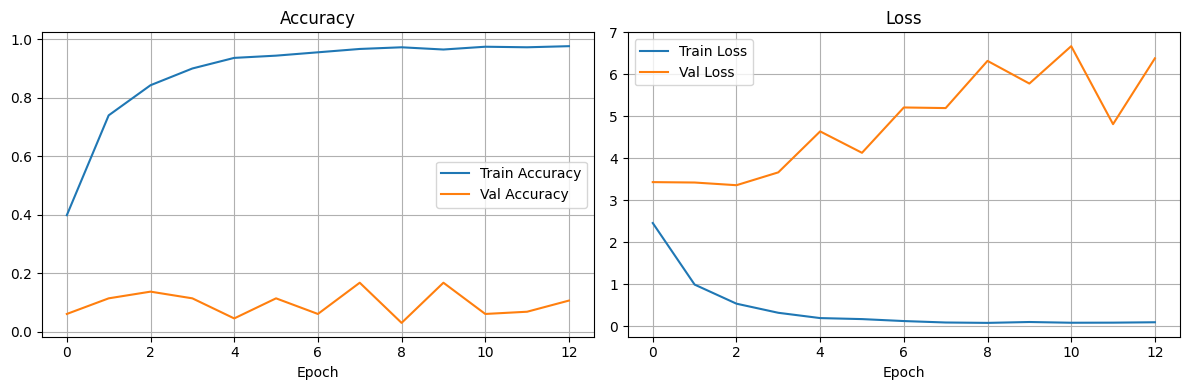

In [14]:
def plot_history(history):
    """
    Plot training and validation accuracy/loss.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()



plot_history(history)

In [15]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Results:")
print(f"  Accuracy: {accuracy * 100:.2f}%")
print(f"  Loss: {loss:.4f}")


Validation Results:
  Accuracy: 13.74%
  Loss: 3.3618


In [38]:
print("Saving model...")
model.save("face_recognition_model.keras")
print("Model saved as 'face_recognition_model.keras'")

Saving model...
Model saved as 'face_recognition_model.keras'


 Visualizing predictions on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


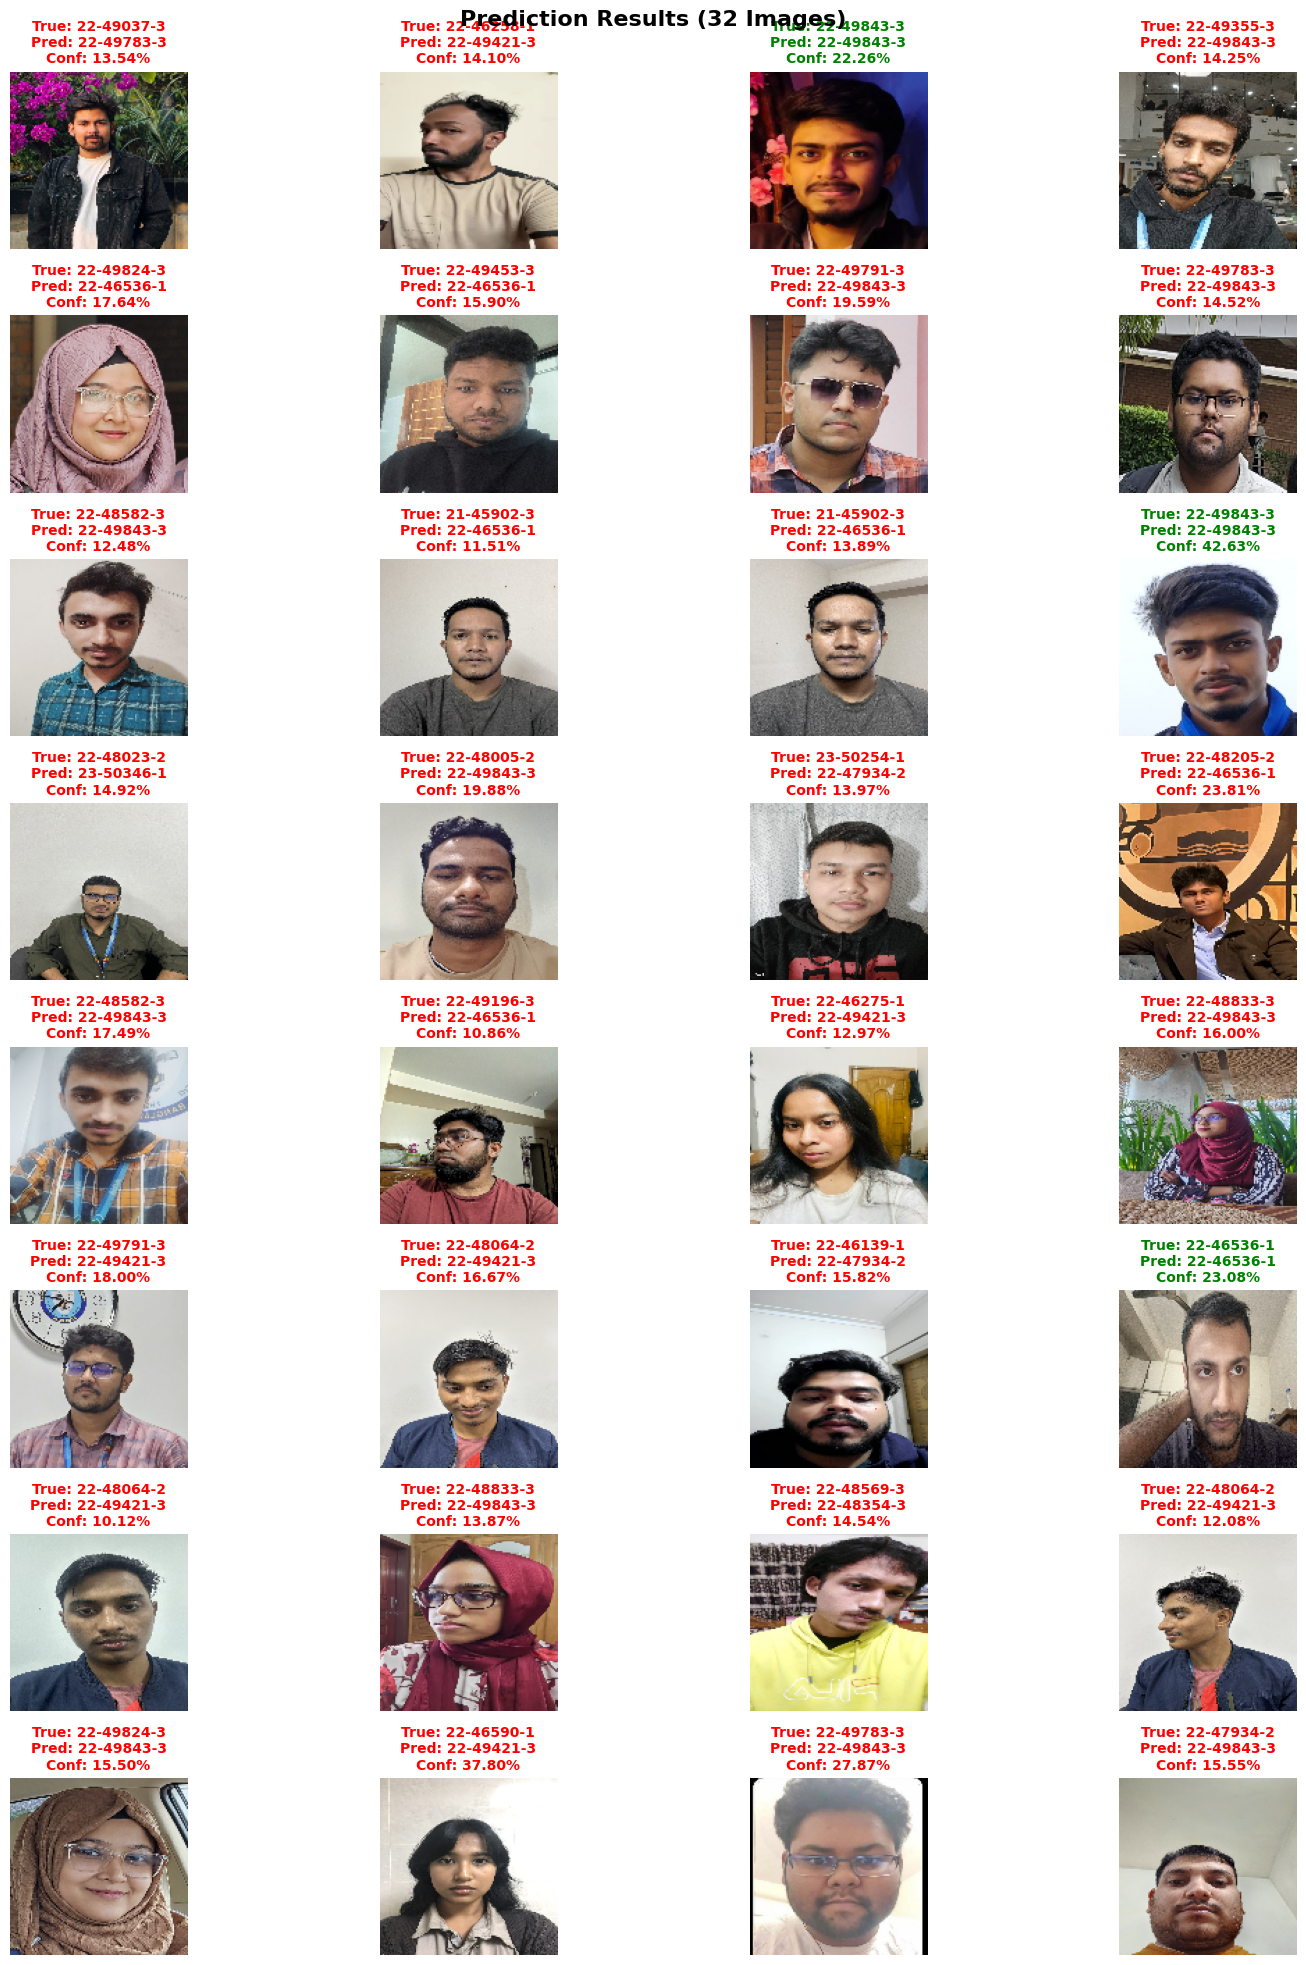

In [39]:
def visualize_predictions(model, X_test, y_test, class_names, num_images=32):
    """
    Green = Correct prediction
    Red = Wrong prediction
    """
    
    # Get predictions
    predictions = model.predict(X_test[:num_images])
    
    # Setup grid: 20 images = 5 rows x 4 cols
    rows = 8
    cols = 4
    
    plt.figure(figsize=(16, 20))
    
    for i in range(num_images):
        # Get true label (from one-hot encoded)
        true_label_idx = np.argmax(y_test[i])
        true_label_name = class_names[true_label_idx]
        
        # Get predicted label
        pred_label_idx = np.argmax(predictions[i])
        pred_label_name = class_names[pred_label_idx]
        
        # Get confidence score
        confidence = predictions[i][pred_label_idx]
        
        # Check if prediction is correct
        is_correct = (true_label_idx == pred_label_idx)
        
        # Display the image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_test[i])
        plt.axis('off')
        
        # Set title with True Label (top) and Predicted Label (bottom)
        title_color = 'green' if is_correct else 'red'
        title_text = f"True: {true_label_name}\n"
        title_text += f"Pred: {pred_label_name}\n"
        title_text += f"Conf: {confidence:.2%}"
        
        plt.title(title_text, fontsize=10, color=title_color, fontweight='bold')
    
    plt.suptitle(f"Prediction Results ({num_images} Images)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# RUN THIS:
print(" Visualizing predictions on test set...")
visualize_predictions(model, X_val, y_val, class_names)


In [ ]:
def load_preprocessed_data(npz_path):
    """
    Load pre-processed face images from .npz file.
    """
    if not os.path.exists(npz_path):
        print(f" File {npz_path} not found!")
        return None, None, None
    
    print(f"Loading preprocessed data from {npz_path}...")
    data = np.load(npz_path, allow_pickle=True)
    
    X = data['X']
    y = data['y']
    class_names = data['class_names']
    
    print("Data loaded successfully!")
    print(f"   Total Images: {X.shape[0]}")
    print(f"   Image Shape: {X.shape[1:]}")
    print(f"   Number of Classes: {len(class_names)}")
    
    return X, y, class_names



print("Loading preprocessed data...")
NPZ_FILE_PATH = "/kaggle/input/process-face-data/full_face_data.npz" 

X_new, y_new, class_names = load_preprocessed_data(NPZ_FILE_PATH)

Loading preprocessed data...
Loading preprocessed data from /kaggle/input/process-face-data/full_face_data.npz...
Data loaded successfully!
   Total Images: 658
   Image Shape: (128, 128, 3)
   Number of Classes: 35


In [19]:
print("Preparing data...")
X_train_new, X_val_new, y_train_new, y_val_new, num_classes = prepare_data(X_new, y_new)

Preparing data...
Number of classes: 35
Label range: 0 to 34

Data Split:
  Training: 526 images
  Validation: 132 images


In [25]:
# IMPROVED CNN MODEL FOR FACE RECOGNITION

def cnn_version_2(img_size=128, num_classes=35):
    """
    Improved CNN:
    - Deeper feature extraction
    - Better generalization
    - Fewer overfitting issues
    """

    model = models.Sequential([
        layers.Input(shape=(img_size, img_size, 3)),

        # ===== Block 1 =====
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),

        # ===== Block 2 =====
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),

        # ===== Block 3 =====
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),

        # ===== Block 4 =====
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.BatchNormalization(),

        # ===== Feature Aggregation =====
        layers.GlobalAveragePooling2D(),

        # ===== Fully Connected Head =====
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # ===== Output =====
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [26]:
print("Building model...")
model_new = cnn_version_2(128, num_classes)
model_new.summary()

Building model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,277,379 (4.87 MB)

 Trainable params: 1,276,419 (4.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [28]:
# Compile
model_new.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
history_new = model_new.fit(
    X_train_new, y_train_new, 
    epochs=50,
    batch_size=32,
    validation_data=(X_val_new, y_val_new),
    callbacks=[early_stop],   
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.0379 - loss: 3.6730 - val_accuracy: 0.0606 - val_loss: 3.5391
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1455 - loss: 3.2823 - val_accuracy: 0.0379 - val_loss: 3.5764
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2208 - loss: 2.9539 - val_accuracy: 0.0303 - val_loss: 3.7761
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2658 - loss: 2.8196 - val_accuracy: 0.0303 - val_loss: 3.8454
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2674 - loss: 2.8032 - val_accuracy: 0.0227 - val_loss: 3.8666
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3381 - loss: 2.4769 - val_accuracy: 0.0227 - val_loss: 3.8663
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3977 - loss: 2.2808 - val_accuracy: 0.0227 - val_loss: 4.0080
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3794 - loss: 2.2399 - val_accuracy: 0.0379 - val_loss:

Plotting new training history...


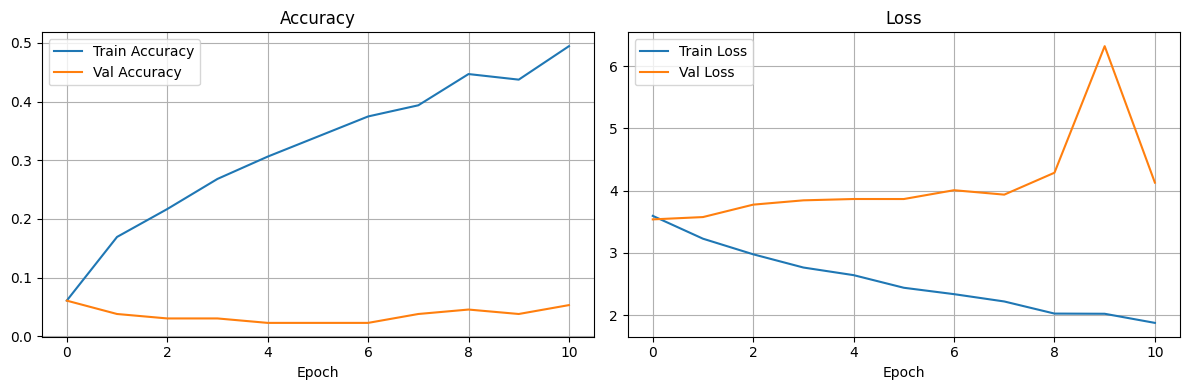

In [31]:
print("Plotting new training history...")
plot_history(history_new)

In [33]:
print("Evaluating model...")
loss, accuracy = model_new.evaluate(X_val_new, y_val_new, verbose=0)
print(f"\nValidation Results:")
print(f"  Accuracy: {accuracy * 100:.2f}%")
print(f"  Loss: {loss:.4f}")

Evaluating model...

Validation Results:
  Accuracy: 6.06%
  Loss: 3.5391


Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


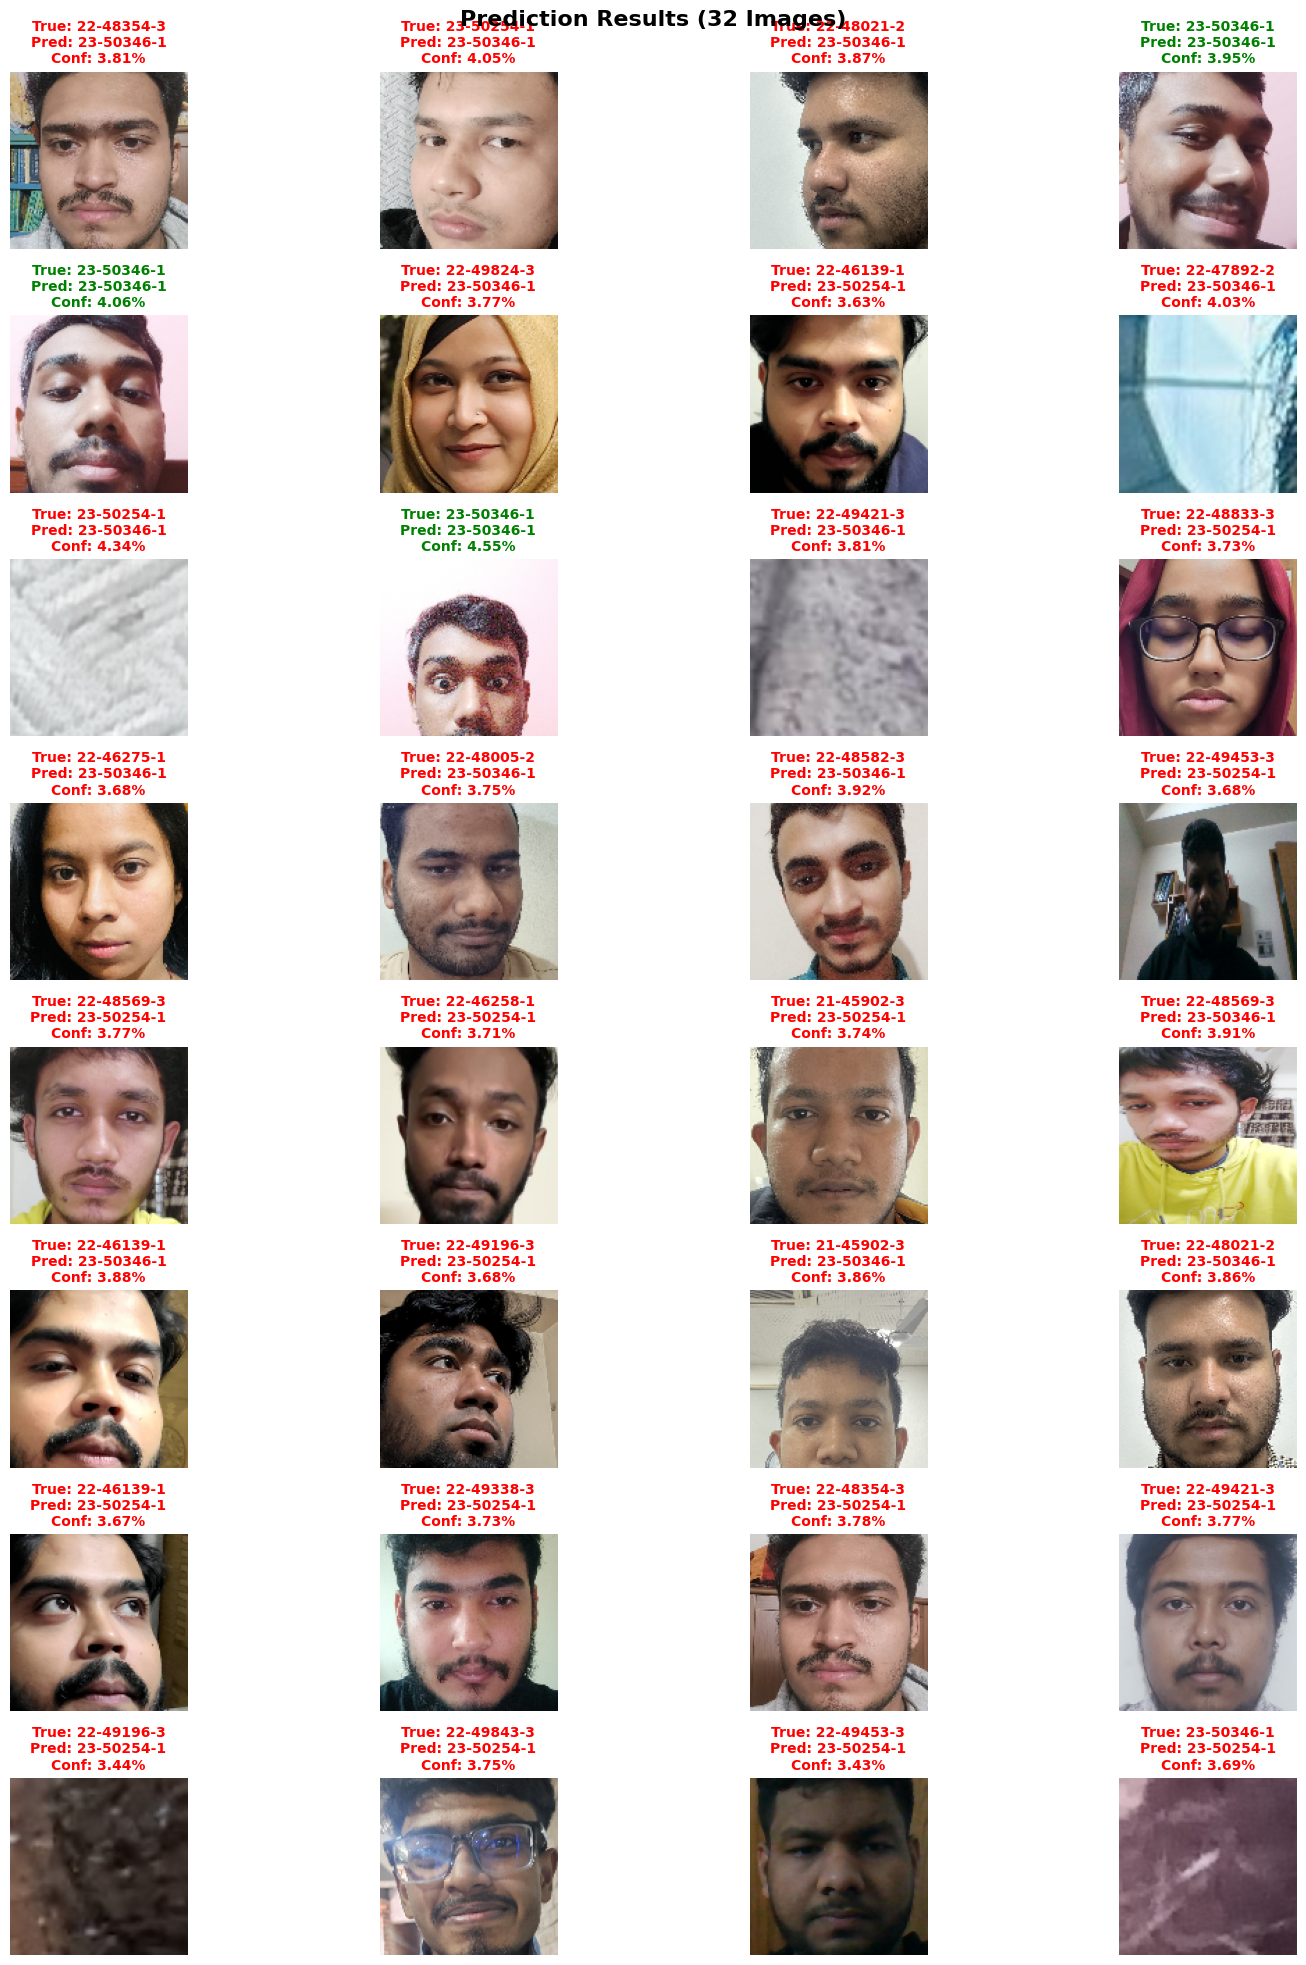

In [35]:
print("Visualizing predictions...")
visualize_predictions(model_new, X_val_new, y_val_new, class_names)

In [37]:
print(" Saving model...")
model_new.save("face_recognition_model_new.keras")
print("Model saved as 'face_recognition_model_new.keras'")

 Saving model...
Model saved as 'face_recognition_model_new.keras'
